## 1. Data Loading & Inspection


(4773, 6)


,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,
2021-01-28,265.000000,483.000000,112.250000,193.600006,58815800.0,193.600006
2021-01-27,354.829987,380.000000,249.000000,347.510010,93396700.0,347.510010
2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996
2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4773 entries, 2021-01-28 to 2002-02-13
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open_price      4773 non-null   float64
 1   high_price      4773 non-null   float64
 2   low_price       4773 non-null   float64
 3   close_price     4773 non-null   float64
 4   volume          4773 non-null   float64
 5   adjclose_price  4773 non-null   float64
dtypes: float64(6)
memory usage: 261.0 KB
None


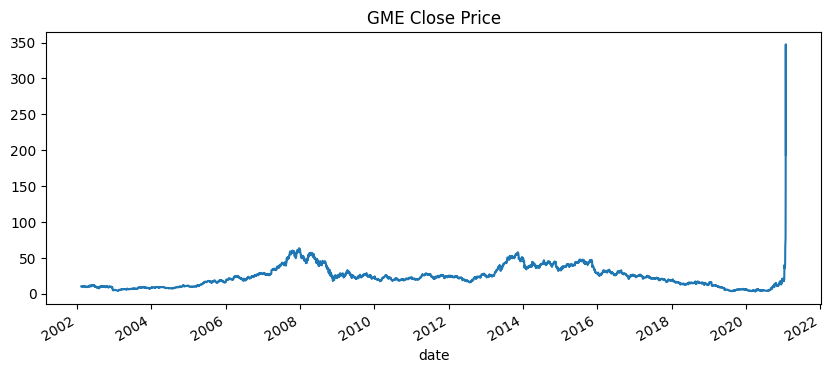

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV, parse dates, set index
df = pd.read_csv(
    'C:/Users/viraj/BuildSpace/Courses/STAT-430 ML TS/A1/GME_stock.csv',
    parse_dates=['date'],
    index_col='date'
)

# Quick look
print(df.shape)
display(df.head())
print(df.info())

# Plot close price
plt.figure(figsize=(10,4))
df['close_price'].plot(title='GME Close Price')
plt.show()


## 2. Cleaning & Missing Values


In [4]:
# Check for gaps/missing
print("Missing values before fill:\n", df.isna().sum())

# Forward-fill
df = df.ffill()

print("Missing values after fill:\n", df.isna().sum())


Missing values before fill:
 open_price        0
high_price        0
low_price         0
close_price       0
volume            0
adjclose_price    0
dtype: int64
Missing values after fill:
 open_price        0
high_price        0
low_price         0
close_price       0
volume            0
adjclose_price    0
dtype: int64


## 3. Feature Engineering


In [ ]:
df['ma_5']  = df['close_price'].rolling(window=5).mean()
df['std_5'] = df['close_price'].rolling(window=5).std()

display(df[['close_price','ma_5','std_5']].head(10))

# Drop rows with NaNs from rolling
df.dropna(inplace=True)
print("After dropna:", df.shape)


,close_price,ma_5,std_5
date,,,
2021-01-28,193.600006,NaN,NaN
2021-01-27,347.510010,NaN,NaN
2021-01-26,147.979996,NaN,NaN
2021-01-25,76.790001,NaN,NaN
2021-01-22,65.010002,166.178003,114.225227
2021-01-21,43.029999,136.064001,124.568063
2021-01-20,39.119999,74.385999,43.979127
2021-01-19,39.360001,52.662000,17.231788
2021-01-15,35.500000,44.404000,11.823060


After dropna: (4769, 8)


## 4. Train / Validation / Test Split


In [6]:
n = len(df)
train_idx = int(n * 0.7)
val_idx   = train_idx + int(n * 0.2)

train = df.iloc[:train_idx]
val   = df.iloc[train_idx:val_idx]
test  = df.iloc[val_idx:]

print("Train / Val / Test sizes:", train.shape, val.shape, test.shape)


Train / Val / Test sizes: (3338, 8) (953, 8) (478, 8)


## 5. Window Generation (Supervised Framing)


In [ ]:
import numpy as np

def create_windows(series, W, H):
    X, y = [], []
    arr = series.values
    for i in range(len(arr) - W - H + 1):
        X.append(arr[i:i+W])
        y.append(arr[i+W:i+W+H])
    return np.array(X), np.array(y)

W = 10     
# 1-step ahead
X_tr1, y_tr1 = create_windows(train['close_price'], W, 1)
X_v1,  y_v1  = create_windows(val['close_price'],   W, 1)
X_te1, y_te1 = create_windows(test['close_price'],  W, 1)

print("1-step shapes:", X_tr1.shape, y_tr1.shape)

# 3-step ahead
X_tr3, y_tr3 = create_windows(train['close_price'], W, 3)
X_v3,  y_v3  = create_windows(val['close_price'],   W, 3)

print("3-step shapes:", X_tr3.shape, y_tr3.shape)


1-step shapes: (3328, 10) (3328, 1)
3-step shapes: (3326, 10) (3326, 3)


## 6. Baseline: “Yesterday’s Price”


In [8]:
from sklearn.metrics import mean_absolute_error

y_pred_base = X_v1[:, -1]           # last value of window
mae_base    = mean_absolute_error(y_v1.flatten(), y_pred_base)
print("Baseline MAE (1-step):", mae_base)


Baseline MAE (1-step): 0.33937964130939635


## 7A. 1-Step Ahead: Fully-Connected Networks


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Architecture 1
model_fcn1 = models.Sequential([
    layers.Input(shape=(W,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_fcn1.compile('adam', 'mse', metrics=['mae'])
print(model_fcn1.summary())
hist1 = model_fcn1.fit(X_tr1, y_tr1, epochs=20, validation_data=(X_v1,y_v1), verbose=0)
print("FCN1 Val MAE:", hist1.history['val_mae'][-1])

# Architecture 2
model_fcn2 = models.Sequential([
    layers.Input(shape=(W,)),
    layers.Dense(128, activation='leaky_relu'),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model_fcn2.compile('adam', 'mse', metrics=['mae'])
print(model_fcn2.summary())
hist2 = model_fcn2.fit(X_tr1, y_tr1, epochs=20, validation_data=(X_v1,y_v1), verbose=0)
print("FCN2 Val MAE:", hist2.history['val_mae'][-1])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
FCN1 Val MAE: 0.382840096950531
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1408      
                                                             

## 7B. 1-Step Ahead: Simple RNNs


In [ ]:
from tensorflow.keras.layers import SimpleRNN

X_tr1_r = X_tr1.reshape(-1, W, 1)
X_v1_r  = X_v1.reshape(-1, W, 1)

# Architecture 1
model_rnn1 = models.Sequential([
    layers.Input(shape=(W,1)),
    SimpleRNN(32),
    layers.Dense(1)
])
model_rnn1.compile('adam','mse',metrics=['mae'])
hist3 = model_rnn1.fit(X_tr1_r, y_tr1, epochs=20, validation_data=(X_v1_r,y_v1), verbose=0)
print("RNN1 Val MAE:", hist3.history['val_mae'][-1])

# Architecture 2
model_rnn2 = models.Sequential([
    layers.Input(shape=(W,1)),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(32),
    layers.Dense(1)
])
model_rnn2.compile('adam','mse',metrics=['mae'])
hist4 = model_rnn2.fit(X_tr1_r, y_tr1, epochs=20, validation_data=(X_v1_r,y_v1), verbose=0)
print("RNN2 Val MAE:", hist4.history['val_mae'][-1])


RNN1 Val MAE: 0.8404712080955505
RNN2 Val MAE: 0.8204792141914368


## 7C. 1-Step Ahead: LSTM Models


In [ ]:
from tensorflow.keras.layers import LSTM

# Architecture 1
model_l1 = models.Sequential([
    layers.Input(shape=(W,1)),
    LSTM(50),
    layers.Dense(1)
])
model_l1.compile('adam','mse',metrics=['mae'])
hist5 = model_l1.fit(X_tr1_r, y_tr1, epochs=20, validation_data=(X_v1_r,y_v1), verbose=0)
print("LSTM1 Val MAE:", hist5.history['val_mae'][-1])

# Architecture 2
model_l2 = models.Sequential([
    layers.Input(shape=(W,1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    layers.Dense(1)
])
model_l2.compile('adam','mse',metrics=['mae'])
hist6 = model_l2.fit(X_tr1_r, y_tr1, epochs=20, validation_data=(X_v1_r,y_v1), verbose=0)
print("LSTM2 Val MAE:", hist6.history['val_mae'][-1])


LSTM1 Val MAE: 0.5221440196037292
LSTM2 Val MAE: 0.7234987616539001


## 8. Compare 1-Step Models


In [12]:
results_1 = {
  'Baseline': mae_base,
  'FCN1': hist1.history['val_mae'][-1],
  'FCN2': hist2.history['val_mae'][-1],
  'RNN1': hist3.history['val_mae'][-1],
  'RNN2': hist4.history['val_mae'][-1],
  'LSTM1': hist5.history['val_mae'][-1],
  'LSTM2': hist6.history['val_mae'][-1]
}
for k,v in results_1.items():
    print(f"{k:6s} -> Val MAE = {v:.4f}")


Baseline -> Val MAE = 0.3394
FCN1   -> Val MAE = 0.3828
FCN2   -> Val MAE = 0.3658
RNN1   -> Val MAE = 0.8405
RNN2   -> Val MAE = 0.8205
LSTM1  -> Val MAE = 0.5221
LSTM2  -> Val MAE = 0.7235


## 9. 3-Step Ahead Forecasting


Create a time series forecasting model for 3-steps ahead forecast (Returning X_{t+1}, X_{t+2}, X_{t+3} at once), using

In [13]:
# Prepare for 3-step
X_tr3_r = X_tr3.reshape(-1, W, 1)
X_v3_r  = X_v3.reshape(-1, W, 1)

# A) FCN multi-output
model_3a = models.Sequential([
    layers.Input(shape=(W,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)
])
model_3a.compile('adam','mse',metrics=['mae'])
hist7 = model_3a.fit(X_tr3, y_tr3, epochs=20, validation_data=(X_v3,y_v3), verbose=0)
print("FCN-3step Val MAE:", hist7.history['val_mae'][-1])

# B) LSTM multi-output
model_3b = models.Sequential([
    layers.Input(shape=(W,1)),
    LSTM(64),
    layers.Dense(3)
])
model_3b.compile('adam','mse',metrics=['mae'])
hist8 = model_3b.fit(X_tr3_r, y_tr3, epochs=20, validation_data=(X_v3_r,y_v3), verbose=0)
print("LSTM-3step Val MAE:", hist8.history['val_mae'][-1])


FCN-3step Val MAE: 0.5145215392112732
LSTM-3step Val MAE: 0.5869243144989014
